## Import Libraries

In [1]:
import pickle
import numpy as np
import pandas as pd
from os import listdir
import pycaret
from pycaret.classification import *
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from datetime import datetime

modalities = ['ACC', 'BVP', 'EDA', 'TEMP']

#sampling frequencies
ACC_WE = 32
BVP_WE = 64
EDA_WE = 4
TEMP_WE = 4

ACC_AD = 1920
BVP_AD = 3840
EDA_AD = 240
TEMP_AD = 240

In [2]:
import gc

gc.collect()

0

## Auxialiary Functions

In [3]:
def take_sample(data):
    """
        @breif Takes a 10% random sample of the data
        @return Returns the 10% sample
    """
    temp = {'data': {'ACC':[], 'BVP':[],'EDA':[],'TEMP':[]},'labels':[], 'id':[]}
    #random indeces for 10% of the data
    index = np.random.choice(np.arange(len(data['labels'])), len(data['labels'])//100, replace=False)
    #take only those indexes
    for feat in modalities:
        temp['data'][feat] = data['data'][feat][index]
    temp['labels'] = data['labels'][index]
    temp['id'] = data['id'][index]
    #return sample
    return temp

In [4]:
def over_sample(data, sampling_strategy='auto'):
    """
        @brief: Generates synthetic stress data to balance the class imbalance
        @param: data (dictionary): Data to create synthetic stress values from
        @param: sampling_strategy: Sampling strategy parameter for under sampler
    """
    print("Initial Data: " + str(np.shape(data['labels'])) + " Stress labels: " +
        str(len(data['labels'][data['labels'] == 1])) + " Nonstress labels: " +
        str(len(data['labels'][data['labels'] == 0])))
    #over sampler
    over = SMOTE(sampling_strategy=sampling_strategy)
    #new data
    ndata = dict()
    #over sample each feature
    for feat in modalities:
        #reshape to make compatible with balancing library
        orig_shape = np.shape(data['data'][feat])
        temp = np.reshape(data['data'][feat], (data['data'][feat].shape[0], data['data'][feat].shape[1]*data['data'][feat].shape[2]))
        #oversample
        ndata[feat], ndata['labels'] = over.fit_resample(temp, data['labels'])
        #revert shaping
        ndata[feat] = ndata[feat].reshape(len(ndata[feat]), orig_shape[1], orig_shape[2])

    print("New Data: " + str(np.shape(ndata['labels'])) + " Stress labels: " +
        str(len(ndata['labels'][ndata['labels'] == 1])) + " Nonstress labels: " +
        str(len(ndata['labels'][ndata['labels'] == 0])))

    return ndata

In [5]:
def create_dataframe_features(data, eda_sf, acc_sf, bvp_sf, tem_sf):
    """
        @brief: Generates a dataframe that contains all of the features
        @param: data (dictionary): Data to create the features dataframe from
        @param: eda_sf: Sampling frequency of electrodermal activity
        @param: acc_sf: Sampling frequency of acceleration
        @param: bvp_sf: Sampling frequency of blood volume pulse
        @param: tem_sf: Sampling frequency of body temperature
    """
    columns_EDA = []
    for i in range(0, eda_sf):
        columns_EDA.append("EDA_"+str(i))
    
    columns_TEMP = []
    for i in range(0, tem_sf):
        columns_TEMP.append("TEMP_"+str(i))
        
    columns_ACC1 = []
    for i in range(0, acc_sf):
        columns_ACC1.append("ACC1_"+str(i))
        
    columns_ACC2 = []
    for i in range(0, acc_sf):
        columns_ACC2.append("ACC2_"+str(i))
        
    columns_ACC3 = []
    for i in range(0, acc_sf):
        columns_ACC3.append("ACC3_"+str(i))
        
    columns_BVP = []
    for i in range(0, bvp_sf):
        columns_BVP.append("BVP_"+str(i))
    
    df1 = pd.DataFrame(data['EDA'][:,:,0], columns=columns_EDA)
    df2 = pd.DataFrame(data['TEMP'][:,:,0], columns=columns_TEMP)
    df3 = pd.DataFrame(data['ACC'][:,:,0], columns=columns_ACC1)
    df4 = pd.DataFrame(data['ACC'][:,:,1], columns=columns_ACC2)
    df5 = pd.DataFrame(data['ACC'][:,:,2], columns=columns_ACC3)
    df6 = pd.DataFrame(data['BVP'][:,:,0], columns=columns_BVP)
    features = pd.concat([df1, df2, df3, df4, df5, df6], axis=1)
    return features
        

In [6]:
def create_dataframe_labels(data):
    """
        @brief: Generates a dataframe that contains the stress labels
        @param: data (dictionary): Data to extract labels from
    """
    labels = pd.DataFrame(data['labels'], columns=["stress"])
    return labels

In [7]:
def create_dataframe_ids(data):
    """
        @brief: Generates a dataframe that contains the participants' ids
        @param: data (dictionary): Data to extract ids from
    """
    ids = pd.DataFrame(data['id'], columns=["id"])
    return ids

In [8]:
from imblearn.over_sampling import SMOTENC

def pycaret_analysis(dataset, target):
    # setup the dataset
    grid = setup(data=dataset, target=target, fix_imbalance = True,  categorical_features=["id"], pca = True, pca_components = 200, html=False, silent=True, verbose=False) #fix_imbalance = True,
    # evaluate models and compare models
    best = compare_models(sort='F1')
    # report the best model
    print(best)
    plot_model(best)
    evaluate_model(best)
    #save_model(best, 'best_model')

In [9]:
def sin_transform(values):
        """
        Applies SIN transform to a series value.
        Args:
            values (pd.Series): A series to apply SIN transform on.
        Returns
            (pd.Series): The transformed series.
        """

        return np.sin(2 * np.pi * values / len(set(values)))

In [10]:
def cos_transform(values):
    """
    Applies COS transform to a series value.
    Args:
        values (pd.Series): A series to apply SIN transform on.
    Returns
        (pd.Series): The transformed series.
    """
    return np.cos(2 * np.pi * values / len(set(values)))

## WESAD

In [41]:
#Load data
wesad = pd.read_pickle('WESAD/All_ID.pkl')

#Create the dataframe of the features
wesad_features = create_dataframe_features(wesad["data"], EDA_WE, ACC_WE, BVP_WE, TEMP_WE)

#Create the dataframe of the labels
wesad_labels = create_dataframe_labels(wesad)

#Create the dataframe of the ids
wesad_ids = create_dataframe_ids(wesad)

#Concatenate features and labels
wesad_dataset = pd.concat([wesad_ids, wesad_features, wesad_labels], axis = 1)


In [42]:
wesad_dataset

,id,EDA_0,EDA_1,EDA_2,EDA_3,TEMP_0,TEMP_1,TEMP_2,TEMP_3,ACC1_0,...,BVP_55,BVP_56,BVP_57,BVP_58,BVP_59,BVP_60,BVP_61,BVP_62,BVP_63,stress
0,2,5452.450365,5366.846848,5264.122627,5115.746165,10279.722091,10279.722091,10279.722091,10279.722091,126.326243,...,-104.371386,-124.493001,-136.216532,-137.408002,-128.387507,-111.782506,-91.536409,-71.450360,-54.013997,0.0
1,2,5264.122627,5115.746165,5127.156998,5013.021944,10279.722091,10279.722091,10279.722091,10279.722091,90.734562,...,40.556707,36.106477,30.326959,25.850055,23.818332,23.653838,23.849453,23.195923,21.515416,0.0
2,2,5127.156998,5013.021944,5372.556718,5235.591090,10279.722091,10279.722091,10279.722091,10279.722091,-27.904372,...,59.620226,48.839201,38.658357,31.562887,28.882079,28.415272,27.312718,22.711332,13.432982,0.0
3,2,5372.556718,5235.591090,5184.228979,5155.692989,10279.722091,10279.722091,10464.748540,10464.748540,-27.904372,...,-92.892373,-97.182554,-94.319469,-83.391734,-65.897576,-45.375840,-26.334550,-12.494826,-5.474934,0.0
4,2,5184.228979,5155.692989,5115.746165,5081.504758,10464.748540,10464.748540,10464.748540,10464.748540,-39.768266,...,-6.795332,-4.105633,-2.803019,-2.358440,-2.225067,-2.042790,-1.833838,-1.958320,-2.878597,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78761,17,-1141.515991,-1141.515991,-1146.439053,-1141.515991,-11412.917628,-11802.683112,-11802.683112,-11802.683112,57.652528,...,13.827887,13.207938,12.701858,12.233733,11.664393,10.917924,9.918415,8.640562,7.097016,0.0
78762,17,-1146.439053,-1141.515991,-1141.515991,-1141.515991,-11802.683112,-11802.683112,-11802.683112,-11802.683112,57.652528,...,-28.632268,-26.405514,-23.444943,-20.092160,-16.562248,-12.918468,-9.186125,-5.339913,-1.519005,0.0
78763,17,-1141.515991,-1141.515991,-1136.589079,-1151.365964,-11802.683112,-11802.683112,-11802.683112,-11802.683112,57.652528,...,12.448817,12.195777,11.816217,11.322788,10.753448,10.146151,9.526202,8.868298,8.045917,0.0
78764,17,-1136.589079,-1151.365964,-1141.515991,-1141.515991,-11802.683112,-11802.683112,-11802.683112,-11412.917628,57.652528,...,-9.110212,-7.427495,-5.491737,-3.189070,-0.544800,2.213339,4.908218,7.350056,9.450290,0.0


In [ ]:
pycaret_analysis(wesad_dataset, "stress")

## ADARP

In [45]:
#Load data
adarp = pd.read_pickle('Formatted_ADARP/Raw/All_ID.pkl')

#In case of the adarp dataset, take a sample (10%) of data and oversample to reduce class imbalance
adarp = take_sample(adarp)
#adarp = over_sample(adarp)

#Create the dataframe of the features
adarp_features = create_dataframe_features(adarp["data"], EDA_AD, ACC_AD, BVP_AD, TEMP_AD)

#Perform PCA to reduce dimensionality in adarp dataset
#pca = PCA(n_components=200)
#adarp_features = pca.fit_transform(adarp_features)

#print(adarp_features.shape)
#print(sum(pca.explained_variance_ratio_))
#adarp_features = pd.DataFrame(adarp_features)

#Create the dataframe of the labels
adarp_labels = create_dataframe_labels(adarp)

#Create the dataframe of the ids
adarp_ids = create_dataframe_ids(adarp)

#Concatenate features and labels
adarp_dataset = pd.concat([adarp_ids, adarp_features, adarp_labels], axis = 1)
#adarp_dataset = pd.concat([adarp_features, adarp_labels], axis = 1)

In [46]:
adarp_dataset

,id,EDA_0,EDA_1,EDA_2,EDA_3,EDA_4,EDA_5,EDA_6,EDA_7,EDA_8,...,BVP_3831,BVP_3832,BVP_3833,BVP_3834,BVP_3835,BVP_3836,BVP_3837,BVP_3838,BVP_3839,stress
0,9,3.719421,3.719421,3.719421,3.192015,3.192015,3.192015,2.138024,3.192015,2.665019,...,-1.800039,-2.921323,-4.046823,-5.159677,-6.276746,-7.364307,-8.338054,-9.050449,-9.311801,0.0
1,4,-403.458482,-403.458482,-403.458482,-403.458482,-403.458482,-403.458482,-403.458482,-403.458482,-403.458482,...,-7.110845,-7.129102,-3.368149,1.917268,5.632578,5.614321,1.908139,-3.240350,-6.727447,0.0
2,9,-62.202300,-62.202300,-64.309870,-64.309870,-64.836865,-65.363860,-66.944435,-66.944435,-66.944435,...,34.380349,32.529808,26.796926,17.712837,5.732800,-8.510883,-24.179356,-40.227211,-55.507871,0.0
3,4,-354.414684,-354.414684,-354.414684,-354.706383,-354.414684,-354.706383,-354.997856,-354.414684,-354.997856,...,4.874910,3.834258,2.811863,1.652540,0.173719,-1.743272,-4.043660,-6.526620,-8.982193,0.0
4,10,-62.557489,-62.557489,-62.557489,-62.557489,-62.557489,-62.557489,-62.557489,-62.557489,-62.557489,...,-0.158053,-0.030701,0.054200,0.085074,0.069637,0.015609,-0.057715,-0.088589,-0.049997,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1630,0,-38.866509,-38.983014,-38.691775,-38.866509,-38.924784,-38.924784,-38.866509,-38.983014,-38.924784,...,21.776537,15.930510,11.353417,9.414665,10.601732,14.308061,19.097263,23.276187,25.434491,0.0
1631,2,-35.373892,-35.373892,-35.797124,-35.373892,-35.797124,-34.950990,-34.527757,-34.950990,-34.950990,...,1.324080,0.669787,-0.022993,-0.742715,-1.416252,-2.008964,-2.524701,-2.967310,-3.382978,0.0
1632,0,-43.339489,-43.222984,-43.106480,-43.281214,-43.164755,-43.339489,-43.222984,-43.339489,-43.339489,...,62.538713,62.542435,62.337768,61.567477,59.331027,54.713001,47.304064,36.013901,22.267738,0.0
1633,4,-353.048109,-351.882447,-353.048109,-353.048109,-353.048109,-352.756636,-353.048109,-351.882447,-353.048109,...,30.498685,28.563438,25.012441,19.927851,13.537882,6.253318,-1.451159,-9.073479,-16.257629,0.0


In [ ]:
#categorical_features=["id"],fix_imbalance = True,
grid = setup(data=adarp_dataset, target='stress', pca = True, pca_components = 200, html=False, silent=True, verbose=False) #fix_imbalance = True,


In [ ]:
grid

In [ ]:
best = compare_models(sort='F1')

In [ ]:
print(best)
plot_model(best)
evaluate_model(best)

In [ ]:
import imblearn
from collections import Counter
from imblearn.over_sampling import SMOTENC

X = adarp_dataset[adarp_dataset.columns.difference(['stress'])].to_numpy()
y = adarp_dataset["stress"].to_numpy()

counter = Counter(adarp_dataset["stress"])
print(counter)

#oversample = SMOTE(sampling_strategy='auto')
oversample = SMOTENC(categorical_features=[200], sampling_strategy='auto')
X_res, y_res = oversample.fit_resample(X, y)

testX = pd.DataFrame(X_res)
testy = pd.DataFrame(y_res, columns=["stress"])
adarp_dataset = pd.concat([testX, testy], axis = 1)

counter = Counter(adarp_dataset["stress"])
print(counter)

In [ ]:
#Perform PCA to reduce dimensionality in adarp dataset
pca = PCA(n_components=200)
X = adarp_dataset[adarp_dataset.columns.difference(['stress'])]
y = adarp_dataset["stress"]
X = pca.fit_transform(X)

print(X.shape)
print(sum(pca.explained_variance_ratio_))
X = pd.DataFrame(X)
adarp_dataset = pd.concat([X, y], axis = 1)





In [ ]:
#wesad_dataset.to_csv('Final_CSVs/wesad_id.csv',index=False)
adarp_dataset.to_csv('Final_CSVs/adarp_id_smote_pca.csv',index=False)

In [ ]:
#wesad_dataset = pd.read_csv('Final_CSVs/wesad_id.csv')
adarp_dataset = pd.read_csv('Final_CSVs/adarp.csv')

In [ ]:
#adarp_dataset=adarp_dataset.drop('id', axis=1)
adarp_dataset = adarp_dataset.drop(200, axis=1)
adarp_dataset

In [ ]:
pycaret_analysis(adarp_dataset, 'stress')

In [ ]:
#df1=dataset.copy()#for later use since pycaret changes the original df

In [ ]:
lightgbm = create_model('lda')
#plot_model(lightgbm, plot = 'confusion_matrix', use_train_data = True)

#plot_model(lightgbm, plot = 'learning', use_train_data = True)

#plot_model(lightgbm,plot="error",use_train_data=True)
plot_model(lightgbm)

## LIFESNAPS

In [11]:
lifesnaps = pd.read_csv('daily_fitbit_sema_df_unprocessed.csv')

In [33]:
lifesnaps

,id,nightly_temperature,nremhr,rmssd,spo2,full_sleep_breathing_rate,daily_temperature_variation,badgeType,calories,filteredDemographicVO2Max,distance,activityType,bpm,lightly_active_minutes,moderately_active_minutes,very_active_minutes,sedentary_minutes,mindfulness_session,scl_avg,resting_hr,sleep_duration,minutesToFallAsleep,minutesAsleep,minutesAwake,minutesAfterWakeup,sleep_efficiency,sleep_deep_ratio,sleep_wake_ratio,sleep_light_ratio,sleep_rem_ratio,steps,minutes_in_default_zone_1,minutes_below_default_zone_1,minutes_in_default_zone_2,minutes_in_default_zone_3,age,gender,bmi,step_goal,min_goal,max_goal,step_goal_label,ENTERTAINMENT,GYM,HOME,HOME_OFFICE,OTHER,OUTDOORS,TRANSIT,WORK/SCHOOL,labels,year,month,weekday,week,day,month_sin,weekday_sin,week_sin,day_sin,month_cos,weekday_cos,week_cos,day_cos
0,621e2e8e67b776a24055b564,34.137687,57.432,89.603,NaN,14.8,-1.788325,NaN,2351.59,62.79210,6517.5,['Walk'],71.701565,149.0,24.0,33.0,713.0,False,NaN,62.073070,31260000.0,0.0,445.0,76.0,0.0,93.0,1.243243,0.987013,0.921642,1.341772,8833.0,83.0,1349.0,0.0,0.0,<30,MALE,<19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2021,5,0,21,24,1.224647e-16,0.000000,1.224647e-16,-0.988468,-1.000000,1.000000,-1.000000,0.151428
1,621e2e8e67b776a24055b564,33.794544,57.681,94.303,NaN,15.8,-2.462709,NaN,2332.08,62.67912,7178.6,['Walk'],70.579300,132.0,25.0,31.0,704.0,False,NaN,62.121476,32880000.0,0.0,460.0,88.0,0.0,94.0,1.466667,1.142857,0.947566,1.197531,9727.0,56.0,1374.0,4.0,0.0,<30,MALE,<19,14999,10000.0,15000.0,10000-14999,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0,2021,5,1,21,25,1.224647e-16,0.781831,1.224647e-16,-0.937752,-1.000000,0.623490,-1.000000,0.347305
2,621e2e8e67b776a24055b564,34.611011,57.481,119.212,NaN,14.6,-2.385801,NaN,2262.30,62.57307,6090.9,['Walk'],71.842573,112.0,27.0,31.0,710.0,False,NaN,62.263999,33600000.0,0.0,493.0,67.0,0.0,96.0,1.116883,0.858974,1.015038,1.670732,8253.0,85.0,1350.0,0.0,0.0,<30,MALE,<19,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,2021,5,2,21,26,1.224647e-16,0.974928,1.224647e-16,-0.848644,-1.000000,-0.222521,-1.000000,0.528964
3,621e2e8e67b776a24055b564,34.408304,57.493,111.709,NaN,14.8,-2.124199,['LIFETIME_DISTANCE'],2325.10,62.47493,6653.1,['Walk'],71.725477,133.0,21.0,37.0,622.0,False,NaN,62.368900,37620000.0,0.0,540.0,87.0,0.0,93.0,1.128205,1.129870,1.191729,1.588235,9015.0,90.0,1282.0,0.0,0.0,<30,MALE,<19,14999,10000.0,15000.0,10000-14999,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0,2021,5,3,21,27,1.224647e-16,0.433884,1.224647e-16,-0.724793,-1.000000,-0.900969,-1.000000,0.688967
4,621e2e8e67b776a24055b564,34.178922,56.750,103.034,NaN,15.2,-2.396873,NaN,2586.76,62.41166,9557.9,['Walk'],74.401028,136.0,42.0,54.0,647.0,False,NaN,61.965409,33660000.0,0.0,493.0,68.0,0.0,94.0,0.910256,0.871795,1.211896,1.090909,12949.0,146.0,1274.0,4.0,0.0,<30,MALE,<19,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,2021,5,4,21,28,1.224647e-16,-0.433884,1.224647e-16,-0.571268,-1.000000,-0.900969,-1.000000,0.820763
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7405,621e362467b776a2404ad513,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,2021,5,1,20,18,1.224647e-16,0.781831,1.490423e-01,-0.485302,-1.000000,0.623490,-0.988831,-0.874347
7406,621e36f967b776a240e5e7c9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0,2021,5,3,20,20,1.224647e-16,0.433884,1.490423e-01,-0.790776,-1.000000,-0.900969,-0.988831,-0.612106
7407,621e362467b776a2404ad513,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [32]:
lifesnaps.columns

Index(['id', 'nightly_temperature', 'nremhr', 'rmssd', 'spo2',
       'full_sleep_breathing_rate', 'daily_temperature_variation', 'badgeType',
       'calories', 'filteredDemographicVO2Max', 'distance', 'activityType',
       'bpm', 'lightly_active_minutes', 'moderately_active_minutes',
       'very_active_minutes', 'sedentary_minutes', 'mindfulness_session',
       'scl_avg', 'resting_hr', 'sleep_duration', 'minutesToFallAsleep',
       'minutesAsleep', 'minutesAwake', 'minutesAfterWakeup',
       'sleep_efficiency', 'sleep_deep_ratio', 'sleep_wake_ratio',
       'sleep_light_ratio', 'sleep_rem_ratio', 'steps',
       'minutes_in_default_zone_1', 'minutes_below_default_zone_1',
       'minutes_in_default_zone_2', 'minutes_in_default_zone_3', 'age',
       'gender', 'bmi', 'step_goal', 'min_goal', 'max_goal', 'step_goal_label',
       'ENTERTAINMENT', 'GYM', 'HOME', 'HOME_OFFICE', 'OTHER', 'OUTDOORS',
       'TRANSIT', 'WORK/SCHOOL', 'labels', 'year', 'month', 'weekday', 'week',
      

In [ ]:
lifesnaps['TENSE/ANXIOUS'].value_counts()

In [ ]:
lifesnaps['ALERT'].value_counts()

In [14]:
lifesnaps["labels"] = np.where(lifesnaps['TENSE/ANXIOUS']== 1, 1, np.where(lifesnaps['ALERT']==1,1, np.where(lifesnaps['SAD']==1,1, 0)))
lifesnaps["labels"].value_counts()

0    6571
1     839
Name: labels, dtype: int64

In [17]:
#Extract features from date
lifesnaps["year"] = lifesnaps["date"].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').year)
lifesnaps["month"] = lifesnaps["date"].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').month)
lifesnaps["weekday"] = lifesnaps["date"].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').weekday())
lifesnaps["week"] = lifesnaps["date"].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').isocalendar()[1])
lifesnaps["day"] = lifesnaps["date"].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').day)

In [18]:
# Sin transformation in date features
lifesnaps["month_sin"] = sin_transform(lifesnaps["month"])
lifesnaps["weekday_sin"] = sin_transform(lifesnaps["weekday"])
lifesnaps["week_sin"] = sin_transform(lifesnaps["week"])
lifesnaps["day_sin"] = sin_transform(lifesnaps["day"])

In [19]:
# Cosine transformation in date features
lifesnaps["month_cos"] = cos_transform(lifesnaps["month"])
lifesnaps["weekday_cos"] = cos_transform(lifesnaps["weekday"])
lifesnaps["week_cos"] = cos_transform(lifesnaps["week"])
lifesnaps["day_cos"] = cos_transform(lifesnaps["day"])

In [30]:
lifesnaps = lifesnaps.drop(columns=['Unnamed: 0', 'date', 'ALERT', 'HAPPY', 'NEUTRAL', 'RESTED/RELAXED', 'SAD', 'TENSE/ANXIOUS','TIRED'])

In [43]:
lifesnaps

,id,nightly_temperature,nremhr,rmssd,spo2,full_sleep_breathing_rate,daily_temperature_variation,badgeType,calories,filteredDemographicVO2Max,...,week,day,month_sin,weekday_sin,week_sin,day_sin,month_cos,weekday_cos,week_cos,day_cos
0,621e2e8e67b776a24055b564,34.137687,57.432,89.603,NaN,14.8,-1.788325,NaN,2351.59,62.79210,...,21,24,1.224647e-16,0.000000,1.224647e-16,-0.988468,-1.000000,1.000000,-1.000000,0.151428
1,621e2e8e67b776a24055b564,33.794544,57.681,94.303,NaN,15.8,-2.462709,NaN,2332.08,62.67912,...,21,25,1.224647e-16,0.781831,1.224647e-16,-0.937752,-1.000000,0.623490,-1.000000,0.347305
2,621e2e8e67b776a24055b564,34.611011,57.481,119.212,NaN,14.6,-2.385801,NaN,2262.30,62.57307,...,21,26,1.224647e-16,0.974928,1.224647e-16,-0.848644,-1.000000,-0.222521,-1.000000,0.528964
3,621e2e8e67b776a24055b564,34.408304,57.493,111.709,NaN,14.8,-2.124199,['LIFETIME_DISTANCE'],2325.10,62.47493,...,21,27,1.224647e-16,0.433884,1.224647e-16,-0.724793,-1.000000,-0.900969,-1.000000,0.688967
4,621e2e8e67b776a24055b564,34.178922,56.750,103.034,NaN,15.2,-2.396873,NaN,2586.76,62.41166,...,21,28,1.224647e-16,-0.433884,1.224647e-16,-0.571268,-1.000000,-0.900969,-1.000000,0.820763
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7405,621e362467b776a2404ad513,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,20,18,1.224647e-16,0.781831,1.490423e-01,-0.485302,-1.000000,0.623490,-0.988831,-0.874347
7406,621e36f967b776a240e5e7c9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,20,20,1.224647e-16,0.433884,1.490423e-01,-0.790776,-1.000000,-0.900969,-0.988831,-0.612106
7407,621e362467b776a2404ad513,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,20,23,1.224647e-16,-0.781831,1.490423e-01,-0.998717,-1.000000,0.623490,-0.988831,-0.050649
7408,621e339967b776a240e502de,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,46,19,5.877853e-01,-0.433884,5.633201e-01,-0.651372,0.809017,-0.900969,0.826239,-0.758758


In [44]:
lifesnaps.to_csv('Final_CSVs/lifesnaps_time.csv',index=False)

In [31]:
lifesnaps_wo_id = lifesnaps.drop(columns=['id'])

In [39]:
lifesnaps_wo_id

,nightly_temperature,nremhr,rmssd,spo2,full_sleep_breathing_rate,daily_temperature_variation,badgeType,calories,filteredDemographicVO2Max,distance,...,week,day,month_sin,weekday_sin,week_sin,day_sin,month_cos,weekday_cos,week_cos,day_cos
0,34.137687,57.432,89.603,NaN,14.8,-1.788325,NaN,2351.59,62.79210,6517.5,...,21,24,1.224647e-16,0.000000,1.224647e-16,-0.988468,-1.000000,1.000000,-1.000000,0.151428
1,33.794544,57.681,94.303,NaN,15.8,-2.462709,NaN,2332.08,62.67912,7178.6,...,21,25,1.224647e-16,0.781831,1.224647e-16,-0.937752,-1.000000,0.623490,-1.000000,0.347305
2,34.611011,57.481,119.212,NaN,14.6,-2.385801,NaN,2262.30,62.57307,6090.9,...,21,26,1.224647e-16,0.974928,1.224647e-16,-0.848644,-1.000000,-0.222521,-1.000000,0.528964
3,34.408304,57.493,111.709,NaN,14.8,-2.124199,['LIFETIME_DISTANCE'],2325.10,62.47493,6653.1,...,21,27,1.224647e-16,0.433884,1.224647e-16,-0.724793,-1.000000,-0.900969,-1.000000,0.688967
4,34.178922,56.750,103.034,NaN,15.2,-2.396873,NaN,2586.76,62.41166,9557.9,...,21,28,1.224647e-16,-0.433884,1.224647e-16,-0.571268,-1.000000,-0.900969,-1.000000,0.820763
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7405,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,20,18,1.224647e-16,0.781831,1.490423e-01,-0.485302,-1.000000,0.623490,-0.988831,-0.874347
7406,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,20,20,1.224647e-16,0.433884,1.490423e-01,-0.790776,-1.000000,-0.900969,-0.988831,-0.612106
7407,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,20,23,1.224647e-16,-0.781831,1.490423e-01,-0.998717,-1.000000,0.623490,-0.988831,-0.050649
7408,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,46,19,5.877853e-01,-0.433884,5.633201e-01,-0.651372,0.809017,-0.900969,0.826239,-0.758758


In [37]:
#categorical_features=["id"],
grid = setup(data=lifesnaps_wo_id, target='labels', fix_imbalance = True, categorical_features=["badgeType","activityType","age","gender","bmi","step_goal","step_goal_label"], html=False, silent=True, verbose=False) #fix_imbalance = True,


In [38]:
best = compare_models(sort='F1')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.8347,0.5698,0.1379,0.0368,0.058,0.0277,0.0391,0.095


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.7281,0.6524,0.3851,0.1772,0.2423,0.1041,0.1156,0.166
lr,Logistic Regression,0.8347,0.5698,0.1379,0.0368,0.0580,0.0277,0.0391,0.095


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
nb,Naive Bayes,0.6221,0.7058,0.7551,0.1959,0.3110,0.1608,0.2301,0.048
knn,K Neighbors Classifier,0.7281,0.6524,0.3851,0.1772,0.2423,0.1041,0.1156,0.166
lr,Logistic Regression,0.8347,0.5698,0.1379,0.0368,0.0580,0.0277,0.0391,0.095


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dt,Decision Tree Classifier,0.8710,0.6881,0.4520,0.4285,0.4376,0.3651,0.3666,0.080
nb,Naive Bayes,0.6221,0.7058,0.7551,0.1959,0.3110,0.1608,0.2301,0.048
knn,K Neighbors Classifier,0.7281,0.6524,0.3851,0.1772,0.2423,0.1041,0.1156,0.166
lr,Logistic Regression,0.8347,0.5698,0.1379,0.0368,0.0580,0.0277,0.0391,0.095


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dt,Decision Tree Classifier,0.8710,0.6881,0.4520,0.4285,0.4376,0.3651,0.3666,0.080
nb,Naive Bayes,0.6221,0.7058,0.7551,0.1959,0.3110,0.1608,0.2301,0.048
knn,K Neighbors Classifier,0.7281,0.6524,0.3851,0.1772,0.2423,0.1041,0.1156,0.166
svm,SVM - Linear Kernel,0.5776,0.0000,0.4000,0.0451,0.0810,0.0000,0.0000,0.256
lr,Logistic Regression,0.8347,0.5698,0.1379,0.0368,0.0580,0.0277,0.0391,0.095


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.8174,0.0000,0.9795,0.3809,0.5481,0.4605,0.5414,0.055
dt,Decision Tree Classifier,0.8710,0.6881,0.4520,0.4285,0.4376,0.3651,0.3666,0.080
nb,Naive Bayes,0.6221,0.7058,0.7551,0.1959,0.3110,0.1608,0.2301,0.048
knn,K Neighbors Classifier,0.7281,0.6524,0.3851,0.1772,0.2423,0.1041,0.1156,0.166
svm,SVM - Linear Kernel,0.5776,0.0000,0.4000,0.0451,0.0810,0.0000,0.0000,0.256
lr,Logistic Regression,0.8347,0.5698,0.1379,0.0368,0.0580,0.0277,0.0391,0.095


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.9061,0.9379,0.5292,0.5936,0.5571,0.5051,0.5074,0.307
ridge,Ridge Classifier,0.8174,0.0000,0.9795,0.3809,0.5481,0.4605,0.5414,0.055
dt,Decision Tree Classifier,0.8710,0.6881,0.4520,0.4285,0.4376,0.3651,0.3666,0.080
nb,Naive Bayes,0.6221,0.7058,0.7551,0.1959,0.3110,0.1608,0.2301,0.048
knn,K Neighbors Classifier,0.7281,0.6524,0.3851,0.1772,0.2423,0.1041,0.1156,0.166
svm,SVM - Linear Kernel,0.5776,0.0000,0.4000,0.0451,0.0810,0.0000,0.0000,0.256
lr,Logistic Regression,0.8347,0.5698,0.1379,0.0368,0.0580,0.0277,0.0391,0.095


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.9061,0.9379,0.5292,0.5936,0.5571,0.5051,0.5074,0.307
ridge,Ridge Classifier,0.8174,0.0000,0.9795,0.3809,0.5481,0.4605,0.5414,0.055
dt,Decision Tree Classifier,0.8710,0.6881,0.4520,0.4285,0.4376,0.3651,0.3666,0.080
qda,Quadratic Discriminant Analysis,0.5696,0.7515,0.9863,0.2286,0.3645,0.2198,0.3364,0.087
nb,Naive Bayes,0.6221,0.7058,0.7551,0.1959,0.3110,0.1608,0.2301,0.048
knn,K Neighbors Classifier,0.7281,0.6524,0.3851,0.1772,0.2423,0.1041,0.1156,0.166
svm,SVM - Linear Kernel,0.5776,0.0000,0.4000,0.0451,0.0810,0.0000,0.0000,0.256
lr,Logistic Regression,0.8347,0.5698,0.1379,0.0368,0.0580,0.0277,0.0391,0.095


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.9061,0.9379,0.5292,0.5936,0.5571,0.5051,0.5074,0.307
ridge,Ridge Classifier,0.8174,0.0000,0.9795,0.3809,0.5481,0.4605,0.5414,0.055
ada,Ada Boost Classifier,0.8853,0.9238,0.5429,0.4952,0.5151,0.4506,0.4528,0.342
dt,Decision Tree Classifier,0.8710,0.6881,0.4520,0.4285,0.4376,0.3651,0.3666,0.080
qda,Quadratic Discriminant Analysis,0.5696,0.7515,0.9863,0.2286,0.3645,0.2198,0.3364,0.087
nb,Naive Bayes,0.6221,0.7058,0.7551,0.1959,0.3110,0.1608,0.2301,0.048
knn,K Neighbors Classifier,0.7281,0.6524,0.3851,0.1772,0.2423,0.1041,0.1156,0.166
svm,SVM - Linear Kernel,0.5776,0.0000,0.4000,0.0451,0.0810,0.0000,0.0000,0.256
lr,Logistic Regression,0.8347,0.5698,0.1379,0.0368,0.0580,0.0277,0.0391,0.095


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.9061,0.9379,0.5292,0.5936,0.5571,0.5051,0.5074,0.307
ridge,Ridge Classifier,0.8174,0.0000,0.9795,0.3809,0.5481,0.4605,0.5414,0.055
gbc,Gradient Boosting Classifier,0.8926,0.9310,0.5618,0.5242,0.5403,0.4798,0.4813,1.364
ada,Ada Boost Classifier,0.8853,0.9238,0.5429,0.4952,0.5151,0.4506,0.4528,0.342
dt,Decision Tree Classifier,0.8710,0.6881,0.4520,0.4285,0.4376,0.3651,0.3666,0.080
qda,Quadratic Discriminant Analysis,0.5696,0.7515,0.9863,0.2286,0.3645,0.2198,0.3364,0.087
nb,Naive Bayes,0.6221,0.7058,0.7551,0.1959,0.3110,0.1608,0.2301,0.048
knn,K Neighbors Classifier,0.7281,0.6524,0.3851,0.1772,0.2423,0.1041,0.1156,0.166
svm,SVM - Linear Kernel,0.5776,0.0000,0.4000,0.0451,0.0810,0.0000,0.0000,0.256
lr,Logistic Regression,0.8347,0.5698,0.1379,0.0368,0.0580,0.0277,0.0391,0.095


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.9061,0.9379,0.5292,0.5936,0.5571,0.5051,0.5074,0.307
lda,Linear Discriminant Analysis,0.8178,0.9275,0.9778,0.3815,0.5483,0.4609,0.5412,0.152
ridge,Ridge Classifier,0.8174,0.0000,0.9795,0.3809,0.5481,0.4605,0.5414,0.055
gbc,Gradient Boosting Classifier,0.8926,0.9310,0.5618,0.5242,0.5403,0.4798,0.4813,1.364
ada,Ada Boost Classifier,0.8853,0.9238,0.5429,0.4952,0.5151,0.4506,0.4528,0.342
dt,Decision Tree Classifier,0.8710,0.6881,0.4520,0.4285,0.4376,0.3651,0.3666,0.080
qda,Quadratic Discriminant Analysis,0.5696,0.7515,0.9863,0.2286,0.3645,0.2198,0.3364,0.087
nb,Naive Bayes,0.6221,0.7058,0.7551,0.1959,0.3110,0.1608,0.2301,0.048
knn,K Neighbors Classifier,0.7281,0.6524,0.3851,0.1772,0.2423,0.1041,0.1156,0.166
svm,SVM - Linear Kernel,0.5776,0.0000,0.4000,0.0451,0.0810,0.0000,0.0000,0.256


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.9076,0.9385,0.5500,0.5999,0.5710,0.5196,0.5218,0.219
rf,Random Forest Classifier,0.9061,0.9379,0.5292,0.5936,0.5571,0.5051,0.5074,0.307
lda,Linear Discriminant Analysis,0.8178,0.9275,0.9778,0.3815,0.5483,0.4609,0.5412,0.152
ridge,Ridge Classifier,0.8174,0.0000,0.9795,0.3809,0.5481,0.4605,0.5414,0.055
gbc,Gradient Boosting Classifier,0.8926,0.9310,0.5618,0.5242,0.5403,0.4798,0.4813,1.364
ada,Ada Boost Classifier,0.8853,0.9238,0.5429,0.4952,0.5151,0.4506,0.4528,0.342
dt,Decision Tree Classifier,0.8710,0.6881,0.4520,0.4285,0.4376,0.3651,0.3666,0.080
qda,Quadratic Discriminant Analysis,0.5696,0.7515,0.9863,0.2286,0.3645,0.2198,0.3364,0.087
nb,Naive Bayes,0.6221,0.7058,0.7551,0.1959,0.3110,0.1608,0.2301,0.048
knn,K Neighbors Classifier,0.7281,0.6524,0.3851,0.1772,0.2423,0.1041,0.1156,0.166


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.9076,0.9385,0.5500,0.5999,0.5710,0.5196,0.5218,0.219
rf,Random Forest Classifier,0.9061,0.9379,0.5292,0.5936,0.5571,0.5051,0.5074,0.307
lda,Linear Discriminant Analysis,0.8178,0.9275,0.9778,0.3815,0.5483,0.4609,0.5412,0.152
ridge,Ridge Classifier,0.8174,0.0000,0.9795,0.3809,0.5481,0.4605,0.5414,0.055
gbc,Gradient Boosting Classifier,0.8926,0.9310,0.5618,0.5242,0.5403,0.4798,0.4813,1.364
lightgbm,Light Gradient Boosting Machine,0.9005,0.9325,0.4777,0.5729,0.5174,0.4628,0.4671,0.295
ada,Ada Boost Classifier,0.8853,0.9238,0.5429,0.4952,0.5151,0.4506,0.4528,0.342
dt,Decision Tree Classifier,0.8710,0.6881,0.4520,0.4285,0.4376,0.3651,0.3666,0.080
qda,Quadratic Discriminant Analysis,0.5696,0.7515,0.9863,0.2286,0.3645,0.2198,0.3364,0.087
nb,Naive Bayes,0.6221,0.7058,0.7551,0.1959,0.3110,0.1608,0.2301,0.048


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.9076,0.9385,0.5500,0.5999,0.5710,0.5196,0.5218,0.219
rf,Random Forest Classifier,0.9061,0.9379,0.5292,0.5936,0.5571,0.5051,0.5074,0.307
lda,Linear Discriminant Analysis,0.8178,0.9275,0.9778,0.3815,0.5483,0.4609,0.5412,0.152
ridge,Ridge Classifier,0.8174,0.0000,0.9795,0.3809,0.5481,0.4605,0.5414,0.055
gbc,Gradient Boosting Classifier,0.8926,0.9310,0.5618,0.5242,0.5403,0.4798,0.4813,1.364
lightgbm,Light Gradient Boosting Machine,0.9005,0.9325,0.4777,0.5729,0.5174,0.4628,0.4671,0.295
ada,Ada Boost Classifier,0.8853,0.9238,0.5429,0.4952,0.5151,0.4506,0.4528,0.342
dt,Decision Tree Classifier,0.8710,0.6881,0.4520,0.4285,0.4376,0.3651,0.3666,0.080
qda,Quadratic Discriminant Analysis,0.5696,0.7515,0.9863,0.2286,0.3645,0.2198,0.3364,0.087
nb,Naive Bayes,0.6221,0.7058,0.7551,0.1959,0.3110,0.1608,0.2301,0.048


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.9076,0.9385,0.5500,0.5999,0.5710,0.5196,0.5218,0.219
rf,Random Forest Classifier,0.9061,0.9379,0.5292,0.5936,0.5571,0.5051,0.5074,0.307
lda,Linear Discriminant Analysis,0.8178,0.9275,0.9778,0.3815,0.5483,0.4609,0.5412,0.152
ridge,Ridge Classifier,0.8174,0.0000,0.9795,0.3809,0.5481,0.4605,0.5414,0.055
gbc,Gradient Boosting Classifier,0.8926,0.9310,0.5618,0.5242,0.5403,0.4798,0.4813,1.364
lightgbm,Light Gradient Boosting Machine,0.9005,0.9325,0.4777,0.5729,0.5174,0.4628,0.4671,0.295
ada,Ada Boost Classifier,0.8853,0.9238,0.5429,0.4952,0.5151,0.4506,0.4528,0.342
dt,Decision Tree Classifier,0.8710,0.6881,0.4520,0.4285,0.4376,0.3651,0.3666,0.080
qda,Quadratic Discriminant Analysis,0.5696,0.7515,0.9863,0.2286,0.3645,0.2198,0.3364,0.087
nb,Naive Bayes,0.6221,0.7058,0.7551,0.1959,0.3110,0.1608,0.2301,0.048


ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=4985, verbose=0,
                     warm_start=False)


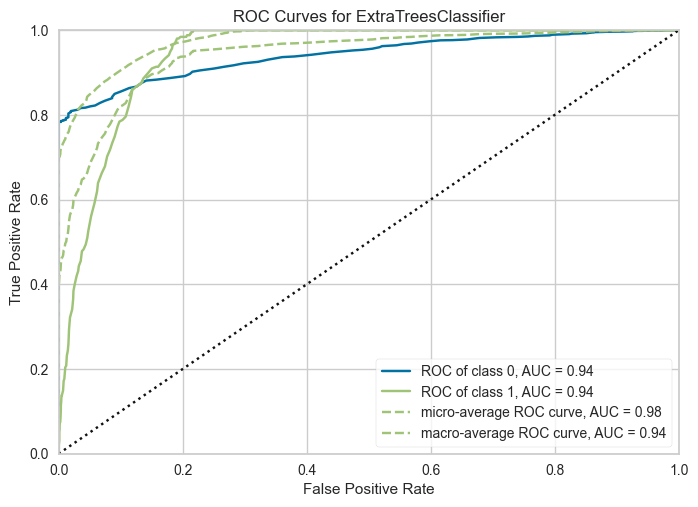

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [40]:
print(best)
plot_model(best)
evaluate_model(best)

In [ ]:
X[1:10,48]

In [ ]:
from sklearn.impute import SimpleImputer
X1 = lifesnaps_wo_id[lifesnaps_wo_id.columns.difference(['labels'])]
imputer = SimpleImputer(strategy="most_frequent")
X2 = imputer.fit_transform(X1) 

X1 = lifesnaps[lifesnaps.columns.difference(['labels'])]
imputer = SimpleImputer(strategy="most_frequent")
X2 = imputer.fit_transform(X1) 

In [ ]:
X = X2#.to_numpy()
y = lifesnaps["labels"].to_numpy()

In [ ]:
X[1:20,0]
np.where(X == '621e2e8e67b776a24055b564')

In [ ]:


counter = Counter(lifesnaps["labels"])
print(counter)

#oversample = SMOTE(sampling_strategy='auto')
#oversample = SMOTENC(categorical_features=[8,9,10,11,15,19,46,47], sampling_strategy='auto')
oversample = SMOTENC(categorical_features=[8,9,10,11,15,19,20,47,48], sampling_strategy='auto')

X_res, y_res = oversample.fit_resample(X, y)

testX = pd.DataFrame(X_res)
testy = pd.DataFrame(y_res, columns=["labels"])
lifesnaps = pd.concat([testX, testy], axis = 1)

counter = Counter(lifesnaps_wo_id["labels"])
print(counter)

In [ ]:
lifesnaps

In [ ]:
lifesnaps.groupby(['ALERT', 'HAPPY', 'NEUTRAL', 'RESTED/RELAXED', 'SAD', 'TENSE/ANXIOUS','TIRED']).size().reset_index().rename(columns={0:'count'})

In [ ]:
pycaret_analysis(lifesnaps, "labels")

## SWELL

In [ ]:
swell = pd.read_csv("SWELL-KW/feature_dataset/swell.csv")

In [ ]:
swell["C"].value_counts()

In [ ]:
swell = swell.drop(columns=["Unnamed: 7", "Unnamed: 8", "Unnamed: 9", "Unnamed: 10", "Unnamed: 11", "timestamp", "C"])

In [ ]:
swell = swell.drop(columns=["PP"])

In [ ]:
swell["Condition"].value_counts()

In [ ]:
swell

In [ ]:
swell['Condition'] = np.where(swell['Condition']=='N','No-Stress',swell['Condition'])
swell['Condition'] = np.where(swell['Condition']=='R','No-Stress',swell['Condition'])
swell['Condition'] = np.where(swell['Condition']=='I','Stress',swell['Condition'])
swell['Condition'] = np.where(swell['Condition']=='T','Stress',swell['Condition'])

In [ ]:
pycaret_analysis(swell, "Condition")